In [1]:
import os
import shutil
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing import image

In [2]:
# Set up relative paths
BASE_DIR = os.getcwd()
DATASET_PATH = os.path.join(BASE_DIR, "Dataset", "train")
TEST_PATH = os.path.join(BASE_DIR, "Dataset", "test", "test")

MODEL_SAVE_PATH = 'best_model.keras'
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS = 60

In [3]:
def prepare_test_folder_structure(test_path):
    """
    Moves test images into subfolders by character names extracted from filenames.
    Creates subfolders if needed.
    """
    for filename in os.listdir(test_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            character_name = "_".join(filename.split('_')[:-1])
            character_dir = os.path.join(test_path, character_name)
            os.makedirs(character_dir, exist_ok=True)
            shutil.move(os.path.join(test_path, filename), os.path.join(character_dir, filename))
    print("✅ All images have been moved to their respective character folders.")
    print()

In [4]:
def sync_test_folders_with_train(test_path, train_path):
    """
    Ensures the test folder has the same character subfolders as the training dataset.
    """
    class_names = [folder for folder in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, folder))]
    for class_name in class_names:
        class_folder = os.path.join(test_path, class_name)
        if not os.path.exists(class_folder):
            os.makedirs(class_folder)
            print(f"Created folder: {class_folder}")
        else:
            print(f"Exists: {class_folder}")
    print("✅ Test folder structure synchronized.")
    print()
    return class_names

In [5]:
def create_data_generators(dataset_path, test_path, img_size, batch_size):
    """
    Creates training, validation and test data generators with augmentation for training.
    """
    train_datagen = keras.preprocessing.image.ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        brightness_range=[0.9, 1.1],
        fill_mode='nearest',
        validation_split=0.2
    )
    validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255, validation_split=0.2)
    test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
        dataset_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='sparse',
        subset='training'
    )
    validation_generator = validation_datagen.flow_from_directory(
        dataset_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='sparse',
        subset='validation'
    )
    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=False  # Important for consistent evaluation
    )
    print()
    return train_generator, validation_generator, test_generator

In [6]:
def build_model(input_shape, num_classes):
    """
    Builds the CNN model architecture.
    """
    model = keras.Sequential([
        layers.ZeroPadding2D(padding=3, input_shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

In [7]:
def get_callbacks(model_save_path):
    """
    Returns callbacks for early stopping, learning rate reduction, and model checkpointing.
    """
    early_stop = EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True
    )
    lr_reduce = ReduceLROnPlateau(
        monitor='val_accuracy', 
        patience=4, 
        factor=0.75, 
        min_lr=1e-5, 
        verbose=1
    )
    checkpoint = ModelCheckpoint(
        filepath=model_save_path, 
        monitor='val_loss', 
        save_best_only=True, 
        mode='min', 
        verbose=1
    )
    return [early_stop, lr_reduce, checkpoint]

In [8]:
def plot_training_history(history):
    """
    Plots training and validation accuracy and loss curves.
    """
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    plt.show()

In [9]:
def train_and_evaluate():
    """
    Main function to prepare data, build model, train, evaluate, and save the best model.
    Measures and prints training time.
    """
    print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")
    print(f"GPU Devices: {tf.config.list_physical_devices('GPU')}")
    print()

    prepare_test_folder_structure(TEST_PATH)
    class_names = sync_test_folders_with_train(TEST_PATH, DATASET_PATH)

    train_gen, val_gen, test_gen = create_data_generators(DATASET_PATH, TEST_PATH, IMG_SIZE, BATCH_SIZE)
    
    model = build_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=len(class_names))
    callbacks = get_callbacks(MODEL_SAVE_PATH)

    start_time = time.time()
    history = model.fit(
        train_gen,
        epochs=EPOCHS,
        validation_data=val_gen,
        callbacks=callbacks
    )
    training_time = time.time() - start_time
    print(f"Training completed in {training_time//60:.0f} min {training_time%60:.0f} sec")

    print("Evaluating on test data...")
    scores = model.evaluate(test_gen)
    print(f"Test loss: {scores[0]}, Test accuracy: {scores[1]}")

    plot_training_history(history)

In [10]:
def load_trained_model_and_predict(image_path, model_path=MODEL_SAVE_PATH):
    """
    Loads the trained model from disk and predicts the class of a given image.
    """
    model = keras.models.load_model(model_path)
    class_names = sorted(os.listdir(DATASET_PATH))  # Ensure same order as training

    img = image.load_img(image_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction[0])
    predicted_class_name = class_names[predicted_class_index]

    print(f"Predicted class for {os.path.basename(image_path)}: {predicted_class_name}")
    print()


Num GPUs Available: 1
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

✅ All images have been moved to their respective character folders.

Exists: C:\Users\lichu\OneDrive\Escritorio\machine-learning\TheSimpsonsClassification\Dataset\test\test\abraham_grampa_simpson
Exists: C:\Users\lichu\OneDrive\Escritorio\machine-learning\TheSimpsonsClassification\Dataset\test\test\agnes_skinner
Exists: C:\Users\lichu\OneDrive\Escritorio\machine-learning\TheSimpsonsClassification\Dataset\test\test\apu_nahasapeemapetilon
Exists: C:\Users\lichu\OneDrive\Escritorio\machine-learning\TheSimpsonsClassification\Dataset\test\test\barney_gumble
Exists: C:\Users\lichu\OneDrive\Escritorio\machine-learning\TheSimpsonsClassification\Dataset\test\test\bart_simpson
Exists: C:\Users\lichu\OneDrive\Escritorio\machine-learning\TheSimpsonsClassification\Dataset\test\test\carl_carlson
Exists: C:\Users\lichu\OneDrive\Escritorio\machine-learning\TheSimpsonsClassification\Dataset\test\test\

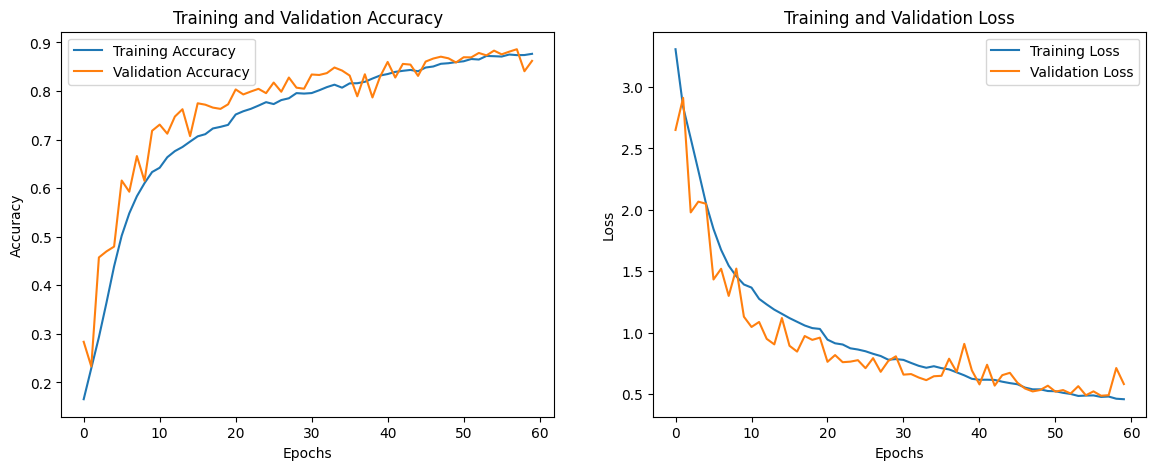

In [11]:
train_and_evaluate()

In [13]:
# Construct the full path to the specific image
image_path = os.path.join(TEST_PATH, "chief_wiggum", "chief_wiggum_9.jpg")

# Now call the function with the dynamically built path
load_trained_model_and_predict(image_path)

1/1 [==============================] - 0s 178ms/step
Predicted class for chief_wiggum_9.jpg: chief_wiggum

